In [11]:
# code ที่ไว้ทำ model
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import librosa
import librosa.display
import joblib
import pickle
import cv2
import warnings
warnings.filterwarnings('ignore')

In [12]:
def extract_advanced_features(audio_path, max_length=6.0):
    """
    สกัดคุณลักษณะที่หลากหลายจากไฟล์เสียง
    """
    try:
        # โหลดไฟล์เสียง
        y, sr = librosa.load(audio_path, sr=22050)
        
        # ปรับความยาวเสียงให้เท่ากัน
        target_length = int(max_length * sr)
        
        if len(y) > target_length:
            y = y[:target_length]
        else:
            # Pad with zeros
            padding = target_length - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # 1. Mel Spectrogram - ให้ความสำคัญมากที่สุด
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, 
                                                fmax=8000, n_fft=2048, hop_length=512)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 2. MFCC - Mel-frequency cepstral coefficients
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        
        # รวม features แบบมัลติ-แชนแนล (3 ช่อง)
        # Normalize features
        mel_spec_norm = (mel_spec_db - np.mean(mel_spec_db)) / (np.std(mel_spec_db) + 1e-10)
        mfcc_norm = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-10)
        delta_norm = (delta_mfcc - np.mean(delta_mfcc)) / (np.std(delta_mfcc) + 1e-10)
        
        # ปรับขนาดให้เท่ากัน
        target_shape = (128, 128)
        mel_spec_resized = cv2.resize(mel_spec_norm, (target_shape[1], target_shape[0]))
        mfcc_resized = cv2.resize(mfcc_norm, (target_shape[1], target_shape[0]))
        delta_resized = cv2.resize(delta_norm, (target_shape[1], target_shape[0]))
        
        # รวมเป็นภาพ 3 ช่อง (RGB-like)
        feature_image = np.stack([mel_spec_resized, mfcc_resized, delta_resized], axis=-1)
        
        # ทำให้ค่าอยู่ระหว่าง 0-1
        feature_image = (feature_image - feature_image.min()) / (feature_image.max() - feature_image.min() + 1e-10)
        
        return feature_image
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {str(e)}")
        return None

def load_and_preprocess_data(data_dir, selected_accents, max_samples=150):
    X = []
    y = []
    file_paths = []
    
    print("กำลังโหลดข้อมูลเสียง...")
    print(f"โฟลเดอร์ข้อมูล: {data_dir}")
    
    # ตรวจสอบว่าโฟลเดอร์ข้อมูลมีอยู่จริง
    if not os.path.exists(data_dir):
        print(f"ไม่พบโฟลเดอร์ข้อมูล: {data_dir}")
        return None, None, None, None
    
    # สร้าง Label Encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(selected_accents)
    
    # โหลดข้อมูลจากแต่ละสำเนียงที่เลือก
    total_files_found = 0
    for accent in selected_accents:
        accent_dir = os.path.join(data_dir, accent)
        if not os.path.isdir(accent_dir):
            print(f"ไม่พบโฟลเดอร์สำหรับสำเนียง {accent} ที่ {accent_dir}")
            continue
        
        accent_files = [os.path.join(accent_dir, f) for f in os.listdir(accent_dir) 
                        if f.endswith('.wav') or f.endswith('.mp3')]
        
        total_files_found += len(accent_files)
        
        # จำกัดจำนวนตัวอย่างต่อสำเนียง
        if max_samples and len(accent_files) > max_samples:
            accent_files = accent_files[:max_samples]
        
        print(f"กำลังประมวลผลสำเนียง {accent}: พบ {len(accent_files)} ไฟล์")
        
        files_processed = 0
        for file_path in accent_files:
            features = extract_advanced_features(file_path)
            if features is not None:
                X.append(features)
                y.append(accent)
                file_paths.append(file_path)
                files_processed += 1
        
        print(f"  - ประมวลผลสำเร็จ {files_processed} ไฟล์")
    
    print(f"พบไฟล์เสียงทั้งหมด: {total_files_found}")
    print(f"ประมวลผลสำเร็จ: {len(X)} ไฟล์")
    
    if len(X) == 0:
        print("ไม่มีข้อมูลที่ประมวลผลได้ โปรดตรวจสอบข้อมูลเสียงของคุณ")
        return None, None, None, None
    
    # แปลง list เป็น numpy array
    X = np.array(X)
    
    # แปลงป้ายกำกับเป็น one-hot encoding
    y_encoded = label_encoder.transform(y)
    y_one_hot = to_categorical(y_encoded)
    
    print(f"โหลดข้อมูลเสร็จสิ้น: {X.shape[0]} ตัวอย่าง, คุณลักษณะ shape: {X.shape[1:]}")
    
    return X, y_one_hot, label_encoder, file_paths

In [13]:
def build_cnn_rnn_model(input_shape, num_classes):
    """
    สร้างโมเดลแบบผสมผสาน CNN + RNN สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN Blocks - สกัดคุณลักษณะเชิงพื้นที่
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Reshape เพื่อให้เข้ากับ RNN
    reshape_dim = K.int_shape(x)
    x = Reshape((reshape_dim[1], reshape_dim[2] * reshape_dim[3]))(x)
    
    # RNN Layers - จับลักษณะเชิงลำดับเวลา
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(128))(x)
    x = Dropout(0.3)(x)
    
    # Global Features
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [14]:
def residual_block(x, filters, kernel_size=3):
    """
    สร้างบล็อก Residual สำหรับโมเดล ResNet
    """
    # แบบ Residual Block ช่วยให้เทรนโมเดลลึกได้มากขึ้น
    y = Conv2D(filters, kernel_size, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    
    # สร้าง shortcut connection
    if K.int_shape(x)[-1] != filters:
        x = Conv2D(filters, 1, padding='same')(x)
        x = BatchNormalization()(x)
    
    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

def build_resnet_model(input_shape, num_classes):
    """
    สร้างโมเดลแบบ ResNet สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(32, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, 32)
    x = residual_block(x, 32)
    x = MaxPooling2D(2, strides=2, padding='same')(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = MaxPooling2D(2, strides=2, padding='same')(x)
    
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [15]:
def positional_encoding(position, d_model):
    """
    สร้าง positional encoding สำหรับ Transformer
    """
    def get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # sin ใช้สำหรับตำแหน่งคู่ (0, 2, 4, ...)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # cos ใช้สำหรับตำแหน่งคี่ (1, 3, 5, ...)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def scaled_dot_product_attention(q, k, v, mask=None):
    """
    คำนวณ scaled dot product attention
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # add mask (optional)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    
    # softmax normalization
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

class MultiHeadAttention(Layer):
    """
    Multi-head attention layer
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        
        self.dense = Dense(d_model)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output

def point_wise_feed_forward_network(d_model, dff):
    """
    Simple feed forward network for transformer
    """
    return Sequential([
        Dense(dff, activation='relu'),
        Dense(d_model)
    ])

class EncoderLayer(Layer):
    """
    Encoder layer for transformer
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, x, training=True):
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

def build_transformer_model(input_shape, num_classes):
    """
    สร้างโมเดล Transformer-based สำหรับการตรวจจับสำเนียง
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # ใช้ CNN เพื่อสกัดคุณลักษณะ
    x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    
    # Reshape สำหรับ Transformer
    shape_before_flatten = K.int_shape(x)
    x = Reshape((shape_before_flatten[1] * shape_before_flatten[2], shape_before_flatten[3]))(x)
    
    # โปรเจคชั่นเป็นมิติของ Transformer
    d_model = 128
    x = Dense(d_model)(x)
    
    # เพิ่ม positional encoding
    seq_len = shape_before_flatten[1] * shape_before_flatten[2]
    pos_encoding = positional_encoding(seq_len, d_model)
    x = x + pos_encoding[:, :seq_len, :]
    
    # Dropout
    x = Dropout(0.2)(x)
    
    # Transformer encoder layers
    num_layers = 2
    for i in range(num_layers):
        x = EncoderLayer(d_model=d_model, num_heads=4, dff=256, rate=0.2)(x)
    
    # Global pooling
    x = GlobalAveragePooling1D()(x)
    
    # Final layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [16]:
def train_model_with_advanced_techniques(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, model_path='model.h5'):
    """
    ฝึกสอนโมเดลด้วยเทคนิคขั้นสูงเพื่อเพิ่มประสิทธิภาพ
    """
    # ระบบ Callbacks ที่หลากหลาย
    callbacks = [
        # บันทึกโมเดลที่ดีที่สุด
        ModelCheckpoint(
            filepath=model_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        # ปรับลด learning rate เมื่อประสิทธิภาพไม่ดีขึ้น
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        # หยุดการฝึกสอนเมื่อไม่มีการพัฒนา
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            verbose=1
        ),
        # บันทึก learning rate ในแต่ละ epoch
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: logs.update({'learning_rate': float(K.get_value(model.optimizer.learning_rate))})
        )
    ]
    
    # Class weight balancing สำหรับข้อมูลที่ไม่สมดุล
    # คำนวณน้ำหนักของแต่ละคลาส
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # ฝึกสอนโมเดล
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # โหลดโมเดลที่ดีที่สุด
    best_model = load_model(model_path)
    
    return history, best_model

In [17]:
def evaluate_and_visualize(model, X_test, y_test, class_names, label_encoder, history=None, is_ensemble=False):
    """
    ประเมินโมเดลและแสดงผลด้วยภาพ
    """
    # ทำนายด้วยชุดข้อมูลทดสอบ
    if is_ensemble:
        y_pred_probs = ensemble_predict(model, X_test)
    else:
        # ประเมินโมเดล
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
        print(f"\nความแม่นยำบนชุดข้อมูลทดสอบ: {test_accuracy * 100:.2f}%")
        y_pred_probs = model.predict(X_test)
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix ด้วย Seaborn
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    
    # แสดงทั้งจำนวนและเปอร์เซ็นต์
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # สร้าง custom annotation
    annot = np.empty_like(cm, dtype=str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    ax = sns.heatmap(cm, annot=cm, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # ปรับปรุงความสวยงาม
    plt.title('Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    # แสดงกราฟประวัติการฝึกสอน
    if history:
        # กราฟความแม่นยำและ loss
        plt.figure(figsize=(16, 6))
        
        # กราฟความแม่นยำ
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], 'o-', linewidth=2, label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], 'o-', linewidth=2, label='Validation Accuracy')
        plt.title('Model Accuracy Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        # กราฟค่าสูญเสีย
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], 'o-', linewidth=2, label='Train Loss')
        plt.plot(history.history['val_loss'], 'o-', linewidth=2, label='Validation Loss')
        plt.title('Model Loss Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300)
        plt.show()
        
        # กราฟการเปรียบเทียบความแม่นยำรายคลาส
        plt.figure(figsize=(12, 10))
        
        # คำนวณความแม่นยำรายคลาส
        class_accuracy = {}
        for i, name in enumerate(class_names):
            # เลือกเฉพาะตัวอย่างที่เป็นคลาสนั้น
            class_indices = np.where(y_true == i)[0]
            class_true = y_true[class_indices]
            class_pred = y_pred[class_indices]
            class_accuracy[name] = accuracy_score(class_true, class_pred) if len(class_indices) > 0 else 0
        
        # เรียงลำดับคลาสตามความแม่นยำ
        sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)
        
        # สร้างกราฟแท่ง
        bars = plt.bar(
            [name.capitalize() for name, _ in sorted_classes],
            [acc * 100 for _, acc in sorted_classes],
            color=[plt.cm.Blues(0.5 + 0.5 * i / len(class_names)) for i in range(len(class_names))]
        )
        
        # เพิ่มค่าบนแท่ง
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12
            )
        
        plt.title
        plt.title('Accuracy by Language/Accent', fontsize=16)
        plt.xlabel('Language', fontsize=14)
        plt.ylabel('Accuracy (%)', fontsize=14)
        plt.ylim(0, 105)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('accuracy_by_language.png', dpi=300)
        plt.show()
    
    # แสดงตัวอย่างการทำนาย
    num_samples = min(5, len(X_test))
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    print("\n===== ตัวอย่างการทำนาย =====")
    for i, idx in enumerate(sample_indices):
        true_class = class_names[np.argmax(y_test[idx])]
        pred_probs = y_pred_probs[idx]
        
        # จัดอันดับการทำนาย
        top_indices = np.argsort(pred_probs)[::-1][:3]
        
        print(f"\nตัวอย่างที่ {i+1}:")
        print(f"สำเนียงจริง: {true_class}")
        
        for j, index in enumerate(top_indices):
            print(f"อันดับ {j+1}: {class_names[index]} - {pred_probs[index]*100:.1f}%")
        

In [18]:
def train_model_with_advanced_techniques(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=32, model_path='model.h5'):
    """
    ฝึกสอนโมเดลด้วยเทคนิคขั้นสูงเพื่อเพิ่มประสิทธิภาพ
    """
    # ระบบ Callbacks ที่หลากหลาย
    callbacks = [
        # บันทึกโมเดลที่ดีที่สุด
        ModelCheckpoint(
            filepath=model_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        # ปรับลด learning rate เมื่อประสิทธิภาพไม่ดีขึ้น
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        # หยุดการฝึกสอนเมื่อไม่มีการพัฒนา
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            verbose=1
        ),
        # บันทึก learning rate ในแต่ละ epoch
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: logs.update({'learning_rate': float(K.get_value(model.optimizer.learning_rate))})
        )
    ]
    
    # Class weight balancing สำหรับข้อมูลที่ไม่สมดุล
    # คำนวณน้ำหนักของแต่ละคลาส
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # ฝึกสอนโมเดล
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    # โหลดโมเดลที่ดีที่สุด
    best_model = load_model(model_path)
    
    return history, best_model
def evaluate_and_visualize(model, X_test, y_test, class_names, label_encoder, history=None, is_ensemble=False):
    """
    ประเมินโมเดลและแสดงผลด้วยภาพ
    """
    # ทำนายด้วยชุดข้อมูลทดสอบ
    if is_ensemble:
        y_pred_probs = ensemble_predict(model, X_test)
    else:
        # ประเมินโมเดล
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
        print(f"\nความแม่นยำบนชุดข้อมูลทดสอบ: {test_accuracy * 100:.2f}%")
        y_pred_probs = model.predict(X_test)
    
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix ด้วย Seaborn
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    
    # แสดงทั้งจำนวนและเปอร์เซ็นต์
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # สร้าง custom annotation
    annot = np.empty_like(cm, dtype=str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    ax = sns.heatmap(cm, annot=cm, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    
    # ปรับปรุงความสวยงาม
    plt.title('Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    # แสดงกราฟประวัติการฝึกสอน
    if history:
        # กราฟความแม่นยำและ loss
        plt.figure(figsize=(16, 6))
        
        # กราฟความแม่นยำ
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], 'o-', linewidth=2, label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], 'o-', linewidth=2, label='Validation Accuracy')
        plt.title('Model Accuracy Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Accuracy', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        # กราฟค่าสูญเสีย
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], 'o-', linewidth=2, label='Train Loss')
        plt.plot(history.history['val_loss'], 'o-', linewidth=2, label='Validation Loss')
        plt.title('Model Loss Over Time', fontsize=16)
        plt.xlabel('Epoch', fontsize=14)
        plt.ylabel('Loss', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300)
        plt.show()
        
        # กราฟการเปรียบเทียบความแม่นยำรายคลาส
        plt.figure(figsize=(12, 10))
        
        # คำนวณความแม่นยำรายคลาส
        class_accuracy = {}
        for i, name in enumerate(class_names):
            # เลือกเฉพาะตัวอย่างที่เป็นคลาสนั้น
            class_indices = np.where(y_true == i)[0]
            class_true = y_true[class_indices]
            class_pred = y_pred[class_indices]
            class_accuracy[name] = accuracy_score(class_true, class_pred) if len(class_indices) > 0 else 0
        
        # เรียงลำดับคลาสตามความแม่นยำ
        sorted_classes = sorted(class_accuracy.items(), key=lambda x: x[1], reverse=True)
        
        # สร้างกราฟแท่ง
        bars = plt.bar(
            [name.capitalize() for name, _ in sorted_classes],
            [acc * 100 for _, acc in sorted_classes],
            color=[plt.cm.Blues(0.5 + 0.5 * i / len(class_names)) for i in range(len(class_names))]
        )
        
        # เพิ่มค่าบนแท่ง
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=12
            )
        
        plt.title
        plt.title('Accuracy by Language/Accent', fontsize=16)
        plt.xlabel('Language', fontsize=14)
        plt.ylabel('Accuracy (%)', fontsize=14)
        plt.ylim(0, 105)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('accuracy_by_language.png', dpi=300)
        plt.show()
    
    # แสดงตัวอย่างการทำนาย
    num_samples = min(5, len(X_test))
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    print("\n===== ตัวอย่างการทำนาย =====")
    for i, idx in enumerate(sample_indices):
        true_class = class_names[np.argmax(y_test[idx])]
        pred_probs = y_pred_probs[idx]
        
        # จัดอันดับการทำนาย
        top_indices = np.argsort(pred_probs)[::-1][:3]
        
        print(f"\nตัวอย่างที่ {i+1}:")
        print(f"สำเนียงจริง: {true_class}")
        
        for j, index in enumerate(top_indices):
            print(f"อันดับ {j+1}: {class_names[index]} - {pred_probs[index]*100:.1f}%")
        def build_ensemble_models(X, y, num_models=2):  # ลดจำนวนโมเดลจาก 3 เป็น 2
            models = []
            input_shape = X.shape[1:]
            num_classes = y.shape[1]
            
            for i in range(num_models):
                print(f"กำลังสร้างโมเดลที่ {i+1}/{num_models}...")
                
                if i == 0:
                    # โมเดลแรกใช้ CNN+RNN Hybrid
                    model = build_cnn_rnn_model(input_shape, num_classes)
                else:
                    # โมเดลที่สองใช้ ResNet
                    model = build_resnet_model(input_shape, num_classes)
                
                models.append(model)
            
            return models

def train_ensemble_models(models, X_train, y_train, X_val, y_val, base_model_path='Model/accent_model'):
    """
    ฝึกสอนโมเดล ensemble แต่ละตัว
    """
    trained_models = []
    histories = []
    
    for i, model in enumerate(models):
        print(f"กำลังฝึกสอนโมเดลที่ {i+1}/{len(models)}...")
        model_path = f"{base_model_path}_{i+1}.h5"
        
        # ฝึกสอนโมเดล
        history, trained_model = train_model_with_advanced_techniques(
            model, X_train, y_train, X_val, y_val,
            epochs=200, batch_size=32, model_path=model_path
        )
        
        trained_models.append(trained_model)
        histories.append(history)
    
    return trained_models, histories

def ensemble_predict(models, X):
    """
    ทำนายโดยใช้ ensemble ของโมเดลหลายตัว
    """
    predictions = []
    
    for model in models:
        pred = model.predict(X)
        predictions.append(pred)
    
    # รวมการทำนายจากทุกโมเดลโดยใช้ค่าเฉลี่ย
    ensemble_pred = np.mean(predictions, axis=0)
    
    return ensemble_pred

In [19]:
def main():
    # กำหนดค่าเริ่มต้น
    data_dir = r"D:\Y2.2\Speech_Accent_Detection\Dataset\augmented_data"  # แก้ไขเป็นโฟลเดอร์ที่เก็บข้อมูลเสียง
    model_dir = "Model"
    
    # สร้างโฟลเดอร์สำหรับเก็บโมเดล
    os.makedirs(model_dir, exist_ok=True)
    
    # เลือกภาษาที่มีลักษณะเสียงแตกต่างกันชัดเจน
    selected_accents = ['thai', 'english', 'mandarin', 'arabic', 'japanese']
    
    # โหลดข้อมูลและเตรียมพร้อม
    result = load_and_preprocess_data(data_dir, selected_accents)
    
    if result[0] is None:
        print("ไม่สามารถดำเนินการต่อได้เนื่องจากไม่มีข้อมูล")
        return
    
    X, y, label_encoder, file_paths = result
    
    # ดำเนินการต่อไป...  
    # บันทึก label encoder ไว้ใช้ในอนาคต
    joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.pkl'))
    
    # แบ่งข้อมูลเป็นชุดฝึกสอน, ชุดตรวจสอบ, และชุดทดสอบ
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1))
    
    print(f"ขนาดข้อมูลฝึกสอน: {X_train.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลตรวจสอบ: {X_val.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลทดสอบ: {X_test.shape[0]} ตัวอย่าง")
    
    # ฝึกสอนโมเดล CNN + RNN hybrid
    print("\n===== กำลังฝึกสอนโมเดล CNN + RNN hybrid =====")
    cnn_rnn_model = build_cnn_rnn_model(X_train.shape[1:], y_train.shape[1])
    cnn_rnn_history, trained_cnn_rnn_model = train_model_with_advanced_techniques(
        cnn_rnn_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
    )
    
    # ประเมินผลโมเดล CNN + RNN hybrid
    print("\n===== ผลลัพธ์การทดสอบโมเดล CNN + RNN hybrid =====")
    class_names = label_encoder.classes_
    evaluate_and_visualize(trained_cnn_rnn_model, X_test, y_test, class_names, label_encoder, cnn_rnn_history)
    
    # ฝึกสอนโมเดล ResNet
    print("\n===== กำลังฝึกสอนโมเดล ResNet =====")
    resnet_model = build_resnet_model(X_train.shape[1:], y_train.shape[1])
    resnet_history, trained_resnet_model = train_model_with_advanced_techniques(
        resnet_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_resnet_model.h5')
    )
    
    # ประเมินผลโมเดล ResNet
    print("\n===== ผลลัพธ์การทดสอบโมเดล ResNet =====")
    evaluate_and_visualize(trained_resnet_model, X_test, y_test, class_names, label_encoder, resnet_history)
    
    # สร้างและฝึกสอนโมเดล Ensemble
    print("\n===== กำลังสร้างและฝึกสอนโมเดล Ensemble =====")
    ensemble_models = build_ensemble_models(X_train, y_train, num_models=3)
    trained_ensemble, ensemble_histories = train_ensemble_models(
        ensemble_models, X_train, y_train, X_val, y_val, 
        base_model_path=os.path.join(model_dir, 'accent_ensemble_model')
    )
    
    # ประเมินผลโมเดล Ensemble
    print("\n===== ผลลัพธ์การทดสอบโมเดล Ensemble =====")
    # ทำนายด้วย ensemble
    ensemble_preds = ensemble_predict(trained_ensemble, X_test)
    y_pred = np.argmax(ensemble_preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล Ensemble =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix สำหรับ Ensemble
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Ensemble Model Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('ensemble_confusion_matrix.png', dpi=300)
    plt.show()
    
    # เปรียบเทียบความแม่นยำของโมเดลทั้งหมด
    plt.figure(figsize=(12, 8))
    
    # ทำนายด้วยแต่ละโมเดล
    cnn_rnn_preds = trained_cnn_rnn_model.predict(X_test)
    cnn_rnn_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(cnn_rnn_preds, axis=1))
    
    resnet_preds = trained_resnet_model.predict(X_test)
    resnet_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(resnet_preds, axis=1))
    
    # ข้อมูลสำหรับกราฟแท่ง
    models = ['CNN+RNN', 'ResNet', 'Transformer', 'Ensemble']
    accuracies = [
        cnn_rnn_acc * 100, 
        resnet_acc * 100, 
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(trained_ensemble[2].predict(X_test), axis=1)) * 100,
        accuracy * 100
    ]
    
    # สร้างกราฟแท่ง
    bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    
    # เพิ่มค่าบนแท่ง
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12
        )
    
    plt.title('Model Comparison: Accuracy', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()
    
    print("\nการฝึกสอนและทดสอบโมเดลเสร็จสิ้น")

กำลังโหลดข้อมูลเสียง...
โฟลเดอร์ข้อมูล: D:\Y2.2\Speech_Accent_Detection\main_datadset
กำลังประมวลผลสำเนียง thai: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง english: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง mandarin: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง arabic: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง japanese: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
กำลังประมวลผลสำเนียง hindi: พบ 150 ไฟล์
  - ประมวลผลสำเร็จ 150 ไฟล์
พบไฟล์เสียงทั้งหมด: 900
ประมวลผลสำเร็จ: 900 ไฟล์
โหลดข้อมูลเสร็จสิ้น: 900 ตัวอย่าง, คุณลักษณะ shape: (128, 128, 3)
ขนาดข้อมูลฝึกสอน: 576 ตัวอย่าง
ขนาดข้อมูลตรวจสอบ: 144 ตัวอย่าง
ขนาดข้อมูลทดสอบ: 180 ตัวอย่าง

===== กำลังฝึกสอนโมเดล CNN + RNN hybrid =====
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.1559 - loss: 2.0316
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.1553 - loss: 2.0300 - val_accuracy: 0.1667 - val_loss: 1.7938 - learning_rate: 3.0000e-04
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.1796 - loss: 1.9352
Epoch 2: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - accuracy: 0.1799 - loss: 1.9324 - val_accuracy: 0.1667 - val_loss: 1.7982 - learning_rate: 3.0000e-04
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.2206 - loss: 1.8152
Epoch 3: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accuracy: 0.2202 - loss: 1.8150 - val_accuracy: 0.1667 - val_loss: 1.8043 - learning_rate: 3.0000e-04
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.1880 - loss: 1.7877
Epoch 4: val_accuracy did not improve from 0.16667
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 426ms/step - accuracy: 0.1883 - loss: 1.7878 - val_accuracy: 0.1667 - val_loss: 1.8104 - learning_rate: 3.0000e-04
Epoch

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 463ms/step - accuracy: 0.3164 - loss: 1.6005 - val_accuracy: 0.1736 - val_loss: 2.0180 - learning_rate: 3.0000e-04
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.4079 - loss: 1.5068
Epoch 11: val_accuracy did not improve from 0.17361

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step - accuracy: 0.4074 - loss: 1.5072 - val_accuracy: 0.1667 - val_loss: 2.0908 - learning_rate: 1.5000e-04
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.4406 - loss: 1.4260
Epoch 12: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.4398 - loss: 1.4271 - val_accuracy: 0.1667 - val_loss: 2.1675 - learning_rate: 1.5000e-04
Epoch 13/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4467 - loss: 1.3638
Epoch 13: val_accuracy improved from 0.17361 to 0.18056, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - accuracy: 0.4465 - loss: 1.3637 - val_accuracy: 0.1806 - val_loss: 2.1682 - learning_rate: 1.5000e-04
Epoch 14/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.4882 - loss: 1.3240
Epoch 14: val_accuracy did not improve from 0.18056
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 608ms/step - accuracy: 0.4885 - loss: 1.3227 - val_accuracy: 0.1806 - val_loss: 2.1132 - learning_rate: 1.5000e-04
Epoch 15/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.5281 - loss: 1.2613
Epoch 15: val_accuracy did not improve from 0.18056
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 551ms/step - accuracy: 0.5295 - loss: 1.2584 - val_accuracy: 0.1736 - val_loss: 2.2063 - learning_rate: 1.5000e-04
Epoch 16/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5441 - loss: 1.1611
Epoch 16: val_accuracy did not improve from 0.18056
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step - accuracy: 0.5437 - loss: 1.1619 - val_accuracy: 0.1667 - val_loss: 2.2987 - learning_rate: 1.5000e-0

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 562ms/step - accuracy: 0.5904 - loss: 1.0906 - val_accuracy: 0.1875 - val_loss: 2.1673 - learning_rate: 1.5000e-04
Epoch 18/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.6804 - loss: 0.9400
Epoch 18: val_accuracy did not improve from 0.18750
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 625ms/step - accuracy: 0.6791 - loss: 0.9414 - val_accuracy: 0.1736 - val_loss: 2.1606 - learning_rate: 1.5000e-04
Epoch 19/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6390 - loss: 0.9114
Epoch 19: val_accuracy improved from 0.18750 to 0.22222, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 507ms/step - accuracy: 0.6403 - loss: 0.9099 - val_accuracy: 0.2222 - val_loss: 2.3637 - learning_rate: 1.5000e-04
Epoch 20/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7116 - loss: 0.8334
Epoch 20: val_accuracy improved from 0.22222 to 0.25694, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - accuracy: 0.7114 - loss: 0.8327 - val_accuracy: 0.2569 - val_loss: 2.4230 - learning_rate: 1.5000e-04
Epoch 21/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7405 - loss: 0.7097
Epoch 21: val_accuracy did not improve from 0.25694

Epoch 21: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 469ms/step - accuracy: 0.7408 - loss: 0.7102 - val_accuracy: 0.2569 - val_loss: 2.3969 - learning_rate: 7.5000e-05
Epoch 22/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8063 - loss: 0.5725
Epoch 22: val_accuracy did not improve from 0.25694
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step - accuracy: 0.8058 - loss: 0.5741 - val_accuracy: 0.2431 - val_loss: 2.5410 - learning_rate: 7.5000e-05
Epoch 23/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8258 - loss: 0.5571
Epoch 23: val_accuracy did not improve from 0.25694
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - accuracy: 0.8262 - loss:

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 515ms/step - accuracy: 0.8370 - loss: 0.4677 - val_accuracy: 0.2639 - val_loss: 2.3152 - learning_rate: 7.5000e-05
Epoch 26/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8632 - loss: 0.4665
Epoch 26: val_accuracy did not improve from 0.26389
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - accuracy: 0.8628 - loss: 0.4663 - val_accuracy: 0.2639 - val_loss: 2.3071 - learning_rate: 7.5000e-05
Epoch 27/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9012 - loss: 0.3796
Epoch 27: val_accuracy improved from 0.26389 to 0.27778, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - accuracy: 0.9011 - loss: 0.3795 - val_accuracy: 0.2778 - val_loss: 2.1175 - learning_rate: 7.5000e-05
Epoch 28/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8937 - loss: 0.3338
Epoch 28: val_accuracy improved from 0.27778 to 0.33333, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 528ms/step - accuracy: 0.8934 - loss: 0.3350 - val_accuracy: 0.3333 - val_loss: 2.0913 - learning_rate: 7.5000e-05
Epoch 29/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8862 - loss: 0.3524
Epoch 29: val_accuracy improved from 0.33333 to 0.34028, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 563ms/step - accuracy: 0.8860 - loss: 0.3522 - val_accuracy: 0.3403 - val_loss: 2.0494 - learning_rate: 7.5000e-05
Epoch 30/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9349 - loss: 0.2664
Epoch 30: val_accuracy improved from 0.34028 to 0.37500, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.9336 - loss: 0.2681 - val_accuracy: 0.3750 - val_loss: 1.9589 - learning_rate: 7.5000e-05
Epoch 31/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9547 - loss: 0.2321
Epoch 31: val_accuracy improved from 0.37500 to 0.45833, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 513ms/step - accuracy: 0.9546 - loss: 0.2327 - val_accuracy: 0.4583 - val_loss: 1.7150 - learning_rate: 7.5000e-05
Epoch 32/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.9365 - loss: 0.2617
Epoch 32: val_accuracy improved from 0.45833 to 0.50000, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 553ms/step - accuracy: 0.9361 - loss: 0.2614 - val_accuracy: 0.5000 - val_loss: 1.5608 - learning_rate: 7.5000e-05
Epoch 33/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9515 - loss: 0.1964
Epoch 33: val_accuracy improved from 0.50000 to 0.55556, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - accuracy: 0.9510 - loss: 0.1978 - val_accuracy: 0.5556 - val_loss: 1.4619 - learning_rate: 7.5000e-05
Epoch 34/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9507 - loss: 0.1877
Epoch 34: val_accuracy improved from 0.55556 to 0.59722, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - accuracy: 0.9503 - loss: 0.1884 - val_accuracy: 0.5972 - val_loss: 1.3532 - learning_rate: 7.5000e-05
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9475 - loss: 0.1937
Epoch 35: val_accuracy improved from 0.59722 to 0.64583, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step - accuracy: 0.9468 - loss: 0.1952 - val_accuracy: 0.6458 - val_loss: 1.3304 - learning_rate: 7.5000e-05
Epoch 36/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9575 - loss: 0.1833
Epoch 36: val_accuracy improved from 0.64583 to 0.68750, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 543ms/step - accuracy: 0.9579 - loss: 0.1823 - val_accuracy: 0.6875 - val_loss: 0.9847 - learning_rate: 7.5000e-05
Epoch 37/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9656 - loss: 0.1444
Epoch 37: val_accuracy did not improve from 0.68750
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 528ms/step - accuracy: 0.9658 - loss: 0.1444 - val_accuracy: 0.6667 - val_loss: 1.0677 - learning_rate: 7.5000e-05
Epoch 38/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9697 - loss: 0.1413
Epoch 38: val_accuracy did not improve from 0.68750
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - accuracy: 0.9693 - loss: 0.1414 - val_accuracy: 0.6875 - val_loss: 1.1141 - learning_rate: 7.5000e-05
Epoch 39/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9728 - loss: 0.1520
Epoch 39: val_accuracy improved from 0.68750 to 0.70139, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.9730 - loss: 0.1511 - val_accuracy: 0.7014 - val_loss: 0.9519 - learning_rate: 7.5000e-05
Epoch 40/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9729 - loss: 0.1325
Epoch 40: val_accuracy did not improve from 0.70139
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step - accuracy: 0.9732 - loss: 0.1316 - val_accuracy: 0.6944 - val_loss: 1.0484 - learning_rate: 7.5000e-05
Epoch 41/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9707 - loss: 0.1431
Epoch 41: val_accuracy improved from 0.70139 to 0.73611, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.9707 - loss: 0.1423 - val_accuracy: 0.7361 - val_loss: 0.9353 - learning_rate: 7.5000e-05
Epoch 42/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9854 - loss: 0.0991
Epoch 42: val_accuracy improved from 0.73611 to 0.74306, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 524ms/step - accuracy: 0.9850 - loss: 0.0998 - val_accuracy: 0.7431 - val_loss: 0.9030 - learning_rate: 7.5000e-05
Epoch 43/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9709 - loss: 0.1106
Epoch 43: val_accuracy did not improve from 0.74306
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 514ms/step - accuracy: 0.9715 - loss: 0.1098 - val_accuracy: 0.7361 - val_loss: 0.9070 - learning_rate: 7.5000e-05
Epoch 44/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9865 - loss: 0.0743
Epoch 44: val_accuracy did not improve from 0.74306
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - accuracy: 0.9865 - loss: 0.0746 - val_accuracy: 0.7361 - val_loss: 0.8773 - learning_rate: 7.5000e-05
Epoch 45/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9864 - loss: 0.0722
Epoch 45: val_accuracy improved from 0.74306 to 0.75694, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - accuracy: 0.9864 - loss: 0.0724 - val_accuracy: 0.7569 - val_loss: 0.8981 - learning_rate: 7.5000e-05
Epoch 46/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9885 - loss: 0.0712
Epoch 46: val_accuracy did not improve from 0.75694
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - accuracy: 0.9885 - loss: 0.0713 - val_accuracy: 0.7431 - val_loss: 0.9567 - learning_rate: 7.5000e-05
Epoch 47/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9985 - loss: 0.0510
Epoch 47: val_accuracy did not improve from 0.75694
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 517ms/step - accuracy: 0.9984 - loss: 0.0512 - val_accuracy: 0.7500 - val_loss: 0.9369 - learning_rate: 7.5000e-05
Epoch 48/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9939 - loss: 0.0605
Epoch 48: val_accuracy did not improve from 0.75694
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 481ms/step - accuracy: 0.9936 - loss: 0.0607 - val_accuracy: 0.7292 - val_loss: 1.0030 - learning_rate: 7.5000e-0

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.9900 - loss: 0.0640 - val_accuracy: 0.7778 - val_loss: 0.9462 - learning_rate: 7.5000e-05
Epoch 51/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9847 - loss: 0.0515
Epoch 51: val_accuracy did not improve from 0.77778
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 525ms/step - accuracy: 0.9848 - loss: 0.0517 - val_accuracy: 0.7569 - val_loss: 1.0064 - learning_rate: 7.5000e-05
Epoch 52/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9820 - loss: 0.0643
Epoch 52: val_accuracy improved from 0.77778 to 0.78472, saving model to Model\accent_cnn_rnn_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 535ms/step - accuracy: 0.9824 - loss: 0.0636 - val_accuracy: 0.7847 - val_loss: 0.9491 - learning_rate: 7.5000e-05
Epoch 53/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.9861 - loss: 0.0561
Epoch 53: val_accuracy did not improve from 0.78472
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 527ms/step - accuracy: 0.9862 - loss: 0.0559 - val_accuracy: 0.7778 - val_loss: 1.0135 - learning_rate: 7.5000e-05
Epoch 54/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9790 - loss: 0.0666
Epoch 54: val_accuracy did not improve from 0.78472

Epoch 54: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - accuracy: 0.9793 - loss: 0.0662 - val_accuracy: 0.7708 - val_loss: 1.0369 - learning_rate: 3.7500e-05
Epoch 55/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9926 - loss: 0.0402
Epoch 55: val_accuracy did not improve from 0.78472
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 517ms/step - accuracy: 0.9926 - lo


===== ผลลัพธ์การทดสอบโมเดล CNN + RNN hybrid =====
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8016 - loss: 0.9702

ความแม่นยำบนชุดข้อมูลทดสอบ: 78.33%
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step

===== รายงานประสิทธิภาพโมเดล =====
Accuracy: 78.33%
Precision: 78.39%
Recall: 78.33%
F1 Score: 78.17%

===== รายงานการจำแนกประเภทโดยละเอียด =====
              precision    recall  f1-score   support

      arabic       0.86      0.80      0.83        30
     english       0.68      0.70      0.69        30
       hindi       0.79      0.87      0.83        30
    japanese       0.90      0.87      0.88        30
    mandarin       0.72      0.60      0.65        30
        thai       0.76      0.87      0.81        30

    accuracy                           0.78       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.78      0.78      0.78       180



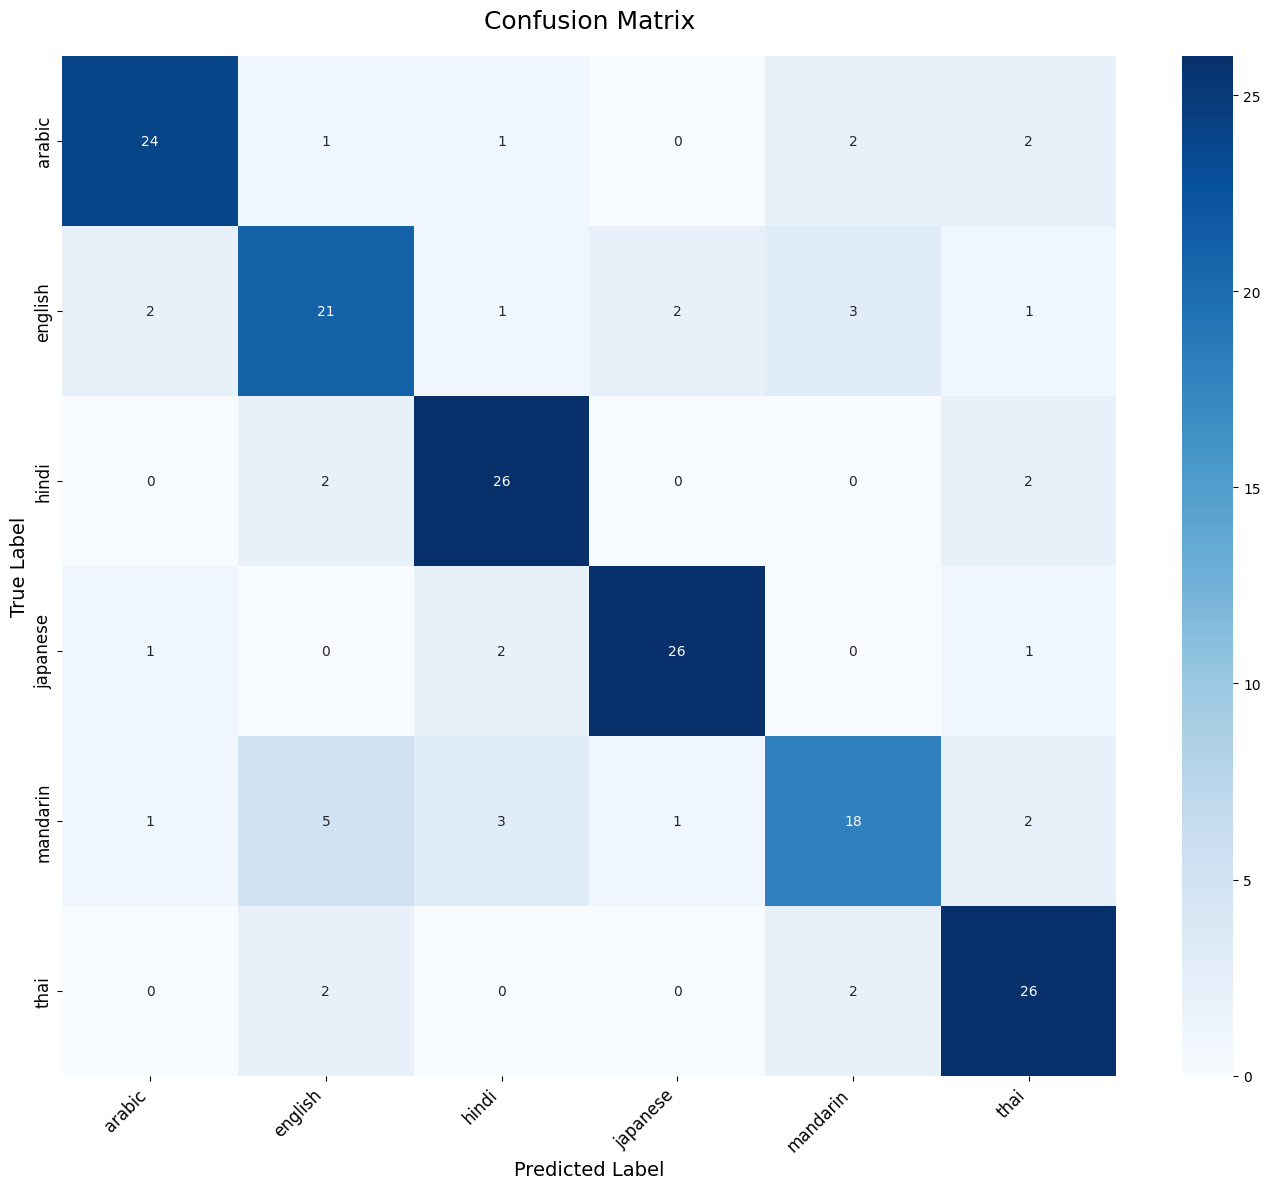

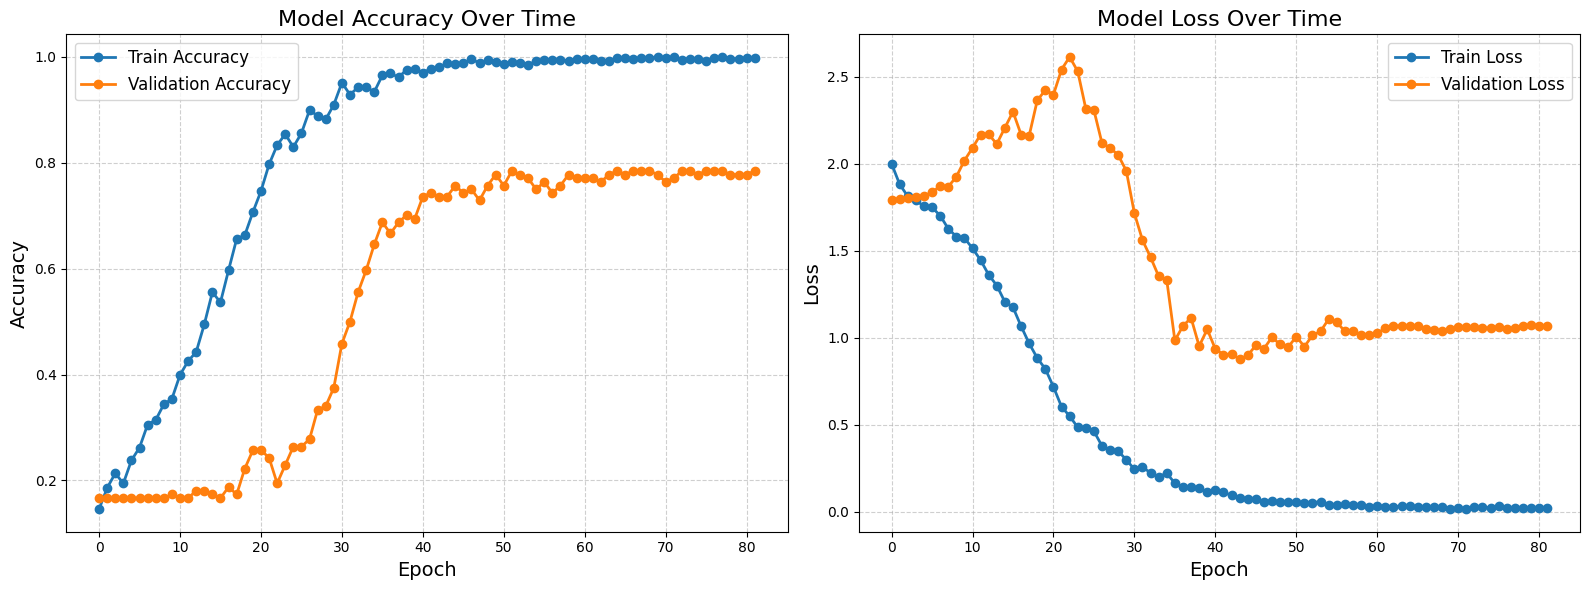

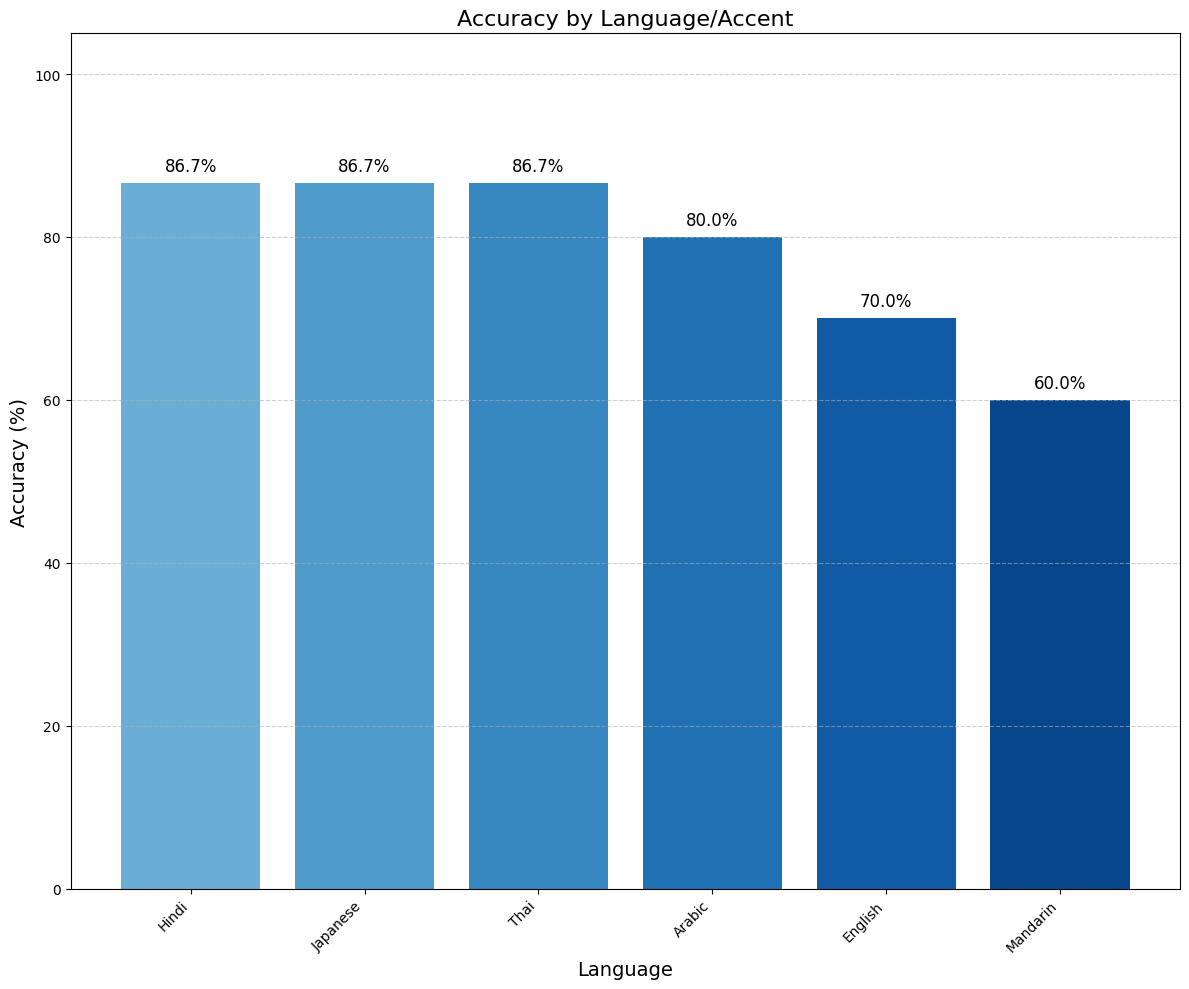


===== ตัวอย่างการทำนาย =====

ตัวอย่างที่ 1:
สำเนียงจริง: thai
อันดับ 1: thai - 88.8%
อันดับ 2: english - 9.1%
อันดับ 3: japanese - 1.7%

ตัวอย่างที่ 2:
สำเนียงจริง: japanese
อันดับ 1: japanese - 99.9%
อันดับ 2: arabic - 0.0%
อันดับ 3: thai - 0.0%

ตัวอย่างที่ 3:
สำเนียงจริง: thai
อันดับ 1: thai - 99.5%
อันดับ 2: japanese - 0.3%
อันดับ 3: english - 0.2%

ตัวอย่างที่ 4:
สำเนียงจริง: thai
อันดับ 1: thai - 99.9%
อันดับ 2: arabic - 0.0%
อันดับ 3: japanese - 0.0%

ตัวอย่างที่ 5:
สำเนียงจริง: arabic
อันดับ 1: thai - 69.1%
อันดับ 2: english - 15.1%
อันดับ 3: mandarin - 12.8%

===== กำลังฝึกสอนโมเดล ResNet =====
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1675 - loss: 1.9710
Epoch 1: val_accuracy improved from -inf to 0.17361, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.1684 - loss: 1.9671 - val_accuracy: 0.1736 - val_loss: 1.7924 - learning_rate: 3.0000e-04
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2242 - loss: 1.7959
Epoch 2: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.2231 - loss: 1.7964 - val_accuracy: 0.1667 - val_loss: 1.7943 - learning_rate: 3.0000e-04
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2733 - loss: 1.7542
Epoch 3: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.2736 - loss: 1.7527 - val_accuracy: 0.1667 - val_loss: 1.7974 - learning_rate: 3.0000e-04
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3316 - loss: 1.6399
Epoch 4: val_accuracy did not improve from 0.17361
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.3321 - loss: 1.6384 - val_accuracy: 0.1667 - val_loss: 1.8047 - learning_rate: 3.0000e-04
Epoch 5/2

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9903 - loss: 0.0358 - val_accuracy: 0.1944 - val_loss: 4.9645 - learning_rate: 7.5000e-05
Epoch 26/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.0228
Epoch 26: val_accuracy did not improve from 0.19444
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0226 - val_accuracy: 0.1875 - val_loss: 5.6801 - learning_rate: 7.5000e-05
Epoch 27/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0198
Epoch 27: val_accuracy improved from 0.19444 to 0.20139, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0197 - val_accuracy: 0.2014 - val_loss: 5.5073 - learning_rate: 7.5000e-05
Epoch 28/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9986 - loss: 0.0140
Epoch 28: val_accuracy improved from 0.20139 to 0.21528, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0141 - val_accuracy: 0.2153 - val_loss: 5.5381 - learning_rate: 7.5000e-05
Epoch 29/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0194
Epoch 29: val_accuracy improved from 0.21528 to 0.26389, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.2639 - val_loss: 4.4630 - learning_rate: 7.5000e-05
Epoch 30/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9998 - loss: 0.0219
Epoch 30: val_accuracy improved from 0.26389 to 0.31944, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0217 - val_accuracy: 0.3194 - val_loss: 2.9292 - learning_rate: 7.5000e-05
Epoch 31/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0154
Epoch 31: val_accuracy improved from 0.31944 to 0.39583, saving model to Model\accent_resnet_model.h5



Epoch 31: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 0.3958 - val_loss: 2.3271 - learning_rate: 3.7500e-05
Epoch 32/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9987 - loss: 0.0136
Epoch 32: val_accuracy improved from 0.39583 to 0.43750, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9986 - loss: 0.0135 - val_accuracy: 0.4375 - val_loss: 2.0707 - learning_rate: 3.7500e-05
Epoch 33/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9984 - loss: 0.0110
Epoch 33: val_accuracy improved from 0.43750 to 0.56250, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9984 - loss: 0.0110 - val_accuracy: 0.5625 - val_loss: 1.5660 - learning_rate: 3.7500e-05
Epoch 34/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0117
Epoch 34: val_accuracy improved from 0.56250 to 0.58333, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.5833 - val_loss: 1.5006 - learning_rate: 3.7500e-05
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9952 - loss: 0.0237
Epoch 35: val_accuracy improved from 0.58333 to 0.59028, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9953 - loss: 0.0234 - val_accuracy: 0.5903 - val_loss: 1.5999 - learning_rate: 3.7500e-05
Epoch 36/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 0.0103
Epoch 36: val_accuracy improved from 0.59028 to 0.65972, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 0.0103 - val_accuracy: 0.6597 - val_loss: 1.4352 - learning_rate: 3.7500e-05
Epoch 37/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9982 - loss: 0.0157
Epoch 37: val_accuracy improved from 0.65972 to 0.75000, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9982 - loss: 0.0157 - val_accuracy: 0.7500 - val_loss: 1.0140 - learning_rate: 3.7500e-05
Epoch 38/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.0110
Epoch 38: val_accuracy improved from 0.75000 to 0.84028, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.8403 - val_loss: 0.6930 - learning_rate: 3.7500e-05
Epoch 39/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.0105
Epoch 39: val_accuracy improved from 0.84028 to 0.84722, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.8472 - val_loss: 0.6162 - learning_rate: 3.7500e-05
Epoch 40/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9984 - loss: 0.0091
Epoch 40: val_accuracy did not improve from 0.84722
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9984 - loss: 0.0092 - val_accuracy: 0.8472 - val_loss: 0.5023 - learning_rate: 3.7500e-05
Epoch 41/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0075
Epoch 41: val_accuracy improved from 0.84722 to 0.86111, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.8611 - val_loss: 0.4918 - learning_rate: 3.7500e-05
Epoch 42/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9999 - loss: 0.0116
Epoch 42: val_accuracy did not improve from 0.86111
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9998 - loss: 0.0116 - val_accuracy: 0.8403 - val_loss: 0.5817 - learning_rate: 3.7500e-05
Epoch 43/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0065
Epoch 43: val_accuracy did not improve from 0.86111
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.8472 - val_loss: 0.5503 - learning_rate: 3.7500e-05
Epoch 44/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9984 - loss: 0.0092
Epoch 44: val_accuracy improved from 0.86111 to 0.86806, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9984 - loss: 0.0092 - val_accuracy: 0.8681 - val_loss: 0.4937 - learning_rate: 3.7500e-05
Epoch 45/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.0052
Epoch 45: val_accuracy did not improve from 0.86806
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.8611 - val_loss: 0.4958 - learning_rate: 3.7500e-05
Epoch 46/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0089
Epoch 46: val_accuracy improved from 0.86806 to 0.88194, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.8819 - val_loss: 0.4723 - learning_rate: 3.7500e-05
Epoch 47/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0092
Epoch 47: val_accuracy improved from 0.88194 to 0.88889, saving model to Model\accent_resnet_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.8889 - val_loss: 0.4635 - learning_rate: 3.7500e-05
Epoch 48/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9993 - loss: 0.0113
Epoch 48: val_accuracy did not improve from 0.88889
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9993 - loss: 0.0113 - val_accuracy: 0.8542 - val_loss: 0.5419 - learning_rate: 3.7500e-05
Epoch 49/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9957 - loss: 0.0121
Epoch 49: val_accuracy did not improve from 0.88889
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9958 - loss: 0.0120 - val_accuracy: 0.8472 - val_loss: 0.5218 - learning_rate: 3.7500e-05
Epoch 50/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 0.0070
Epoch 50: val_accuracy did not improve from 0.88889
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8611 - val_loss: 0.5046 - learning_rate: 3.7500e-05



===== ผลลัพธ์การทดสอบโมเดล ResNet =====
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8461 - loss: 0.5545

ความแม่นยำบนชุดข้อมูลทดสอบ: 83.89%
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

===== รายงานประสิทธิภาพโมเดล =====
Accuracy: 83.89%
Precision: 84.03%
Recall: 83.89%
F1 Score: 83.86%

===== รายงานการจำแนกประเภทโดยละเอียด =====
              precision    recall  f1-score   support

      arabic       0.93      0.90      0.92        30
     english       0.81      0.70      0.75        30
       hindi       0.90      0.90      0.90        30
    japanese       0.90      0.93      0.92        30
    mandarin       0.62      0.67      0.65        30
        thai       0.88      0.93      0.90        30

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180



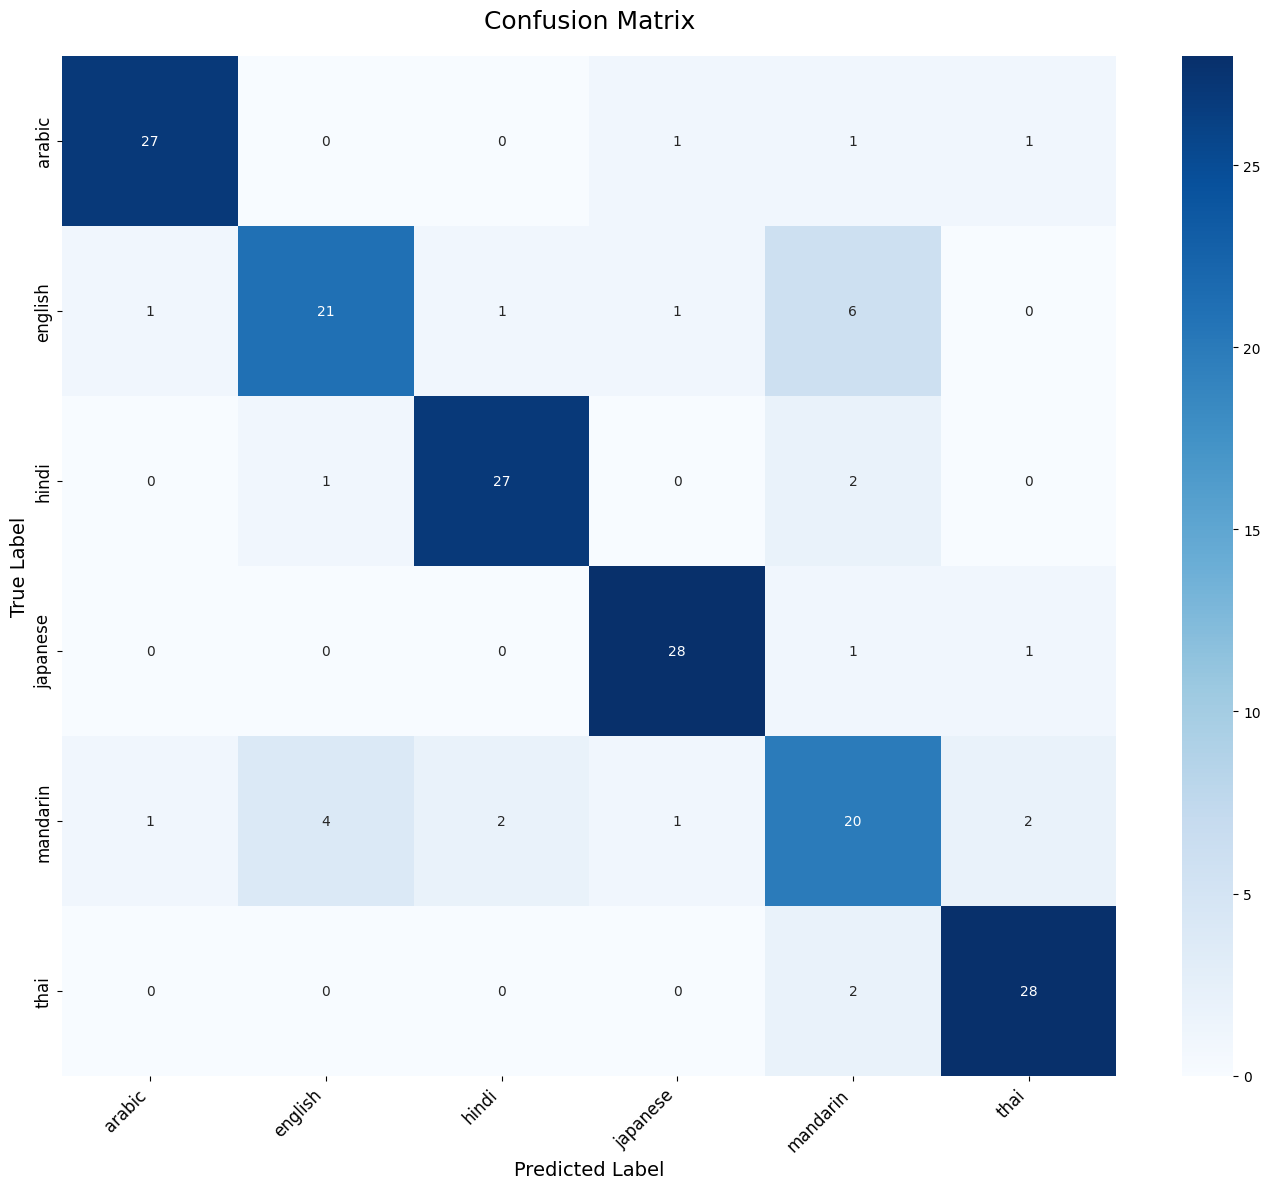

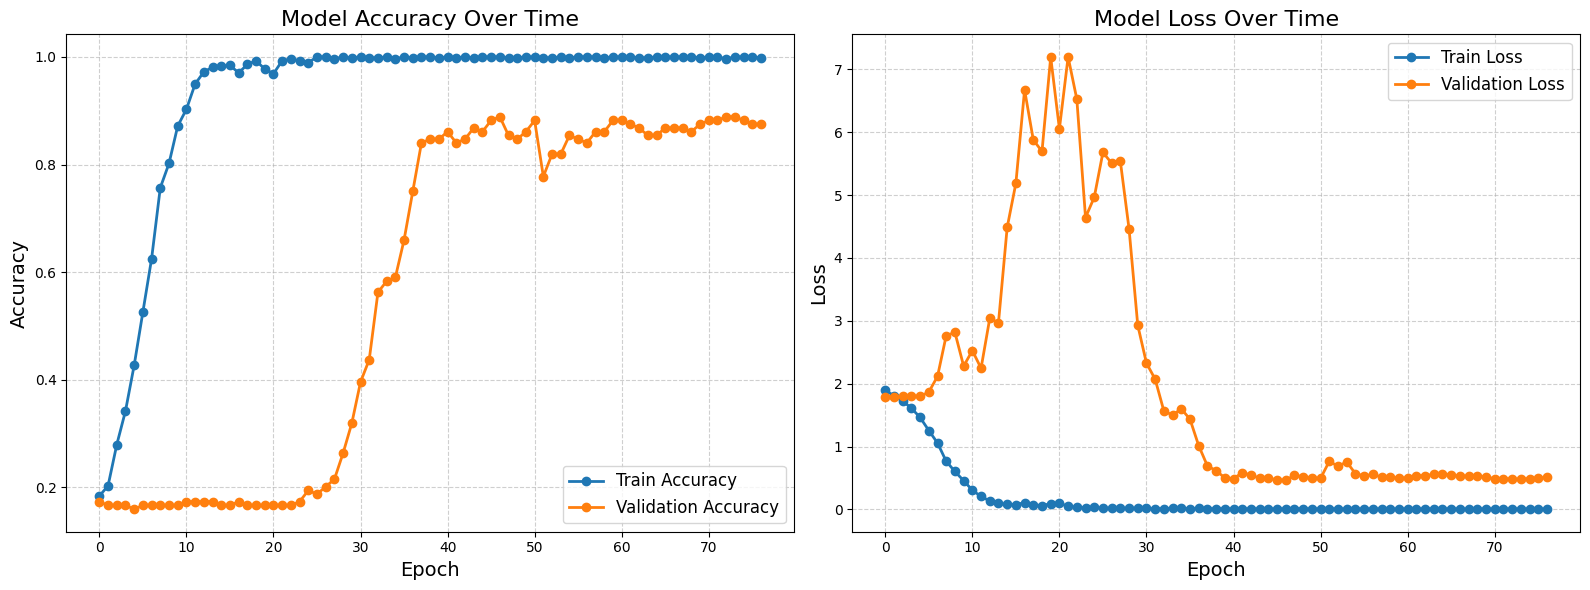

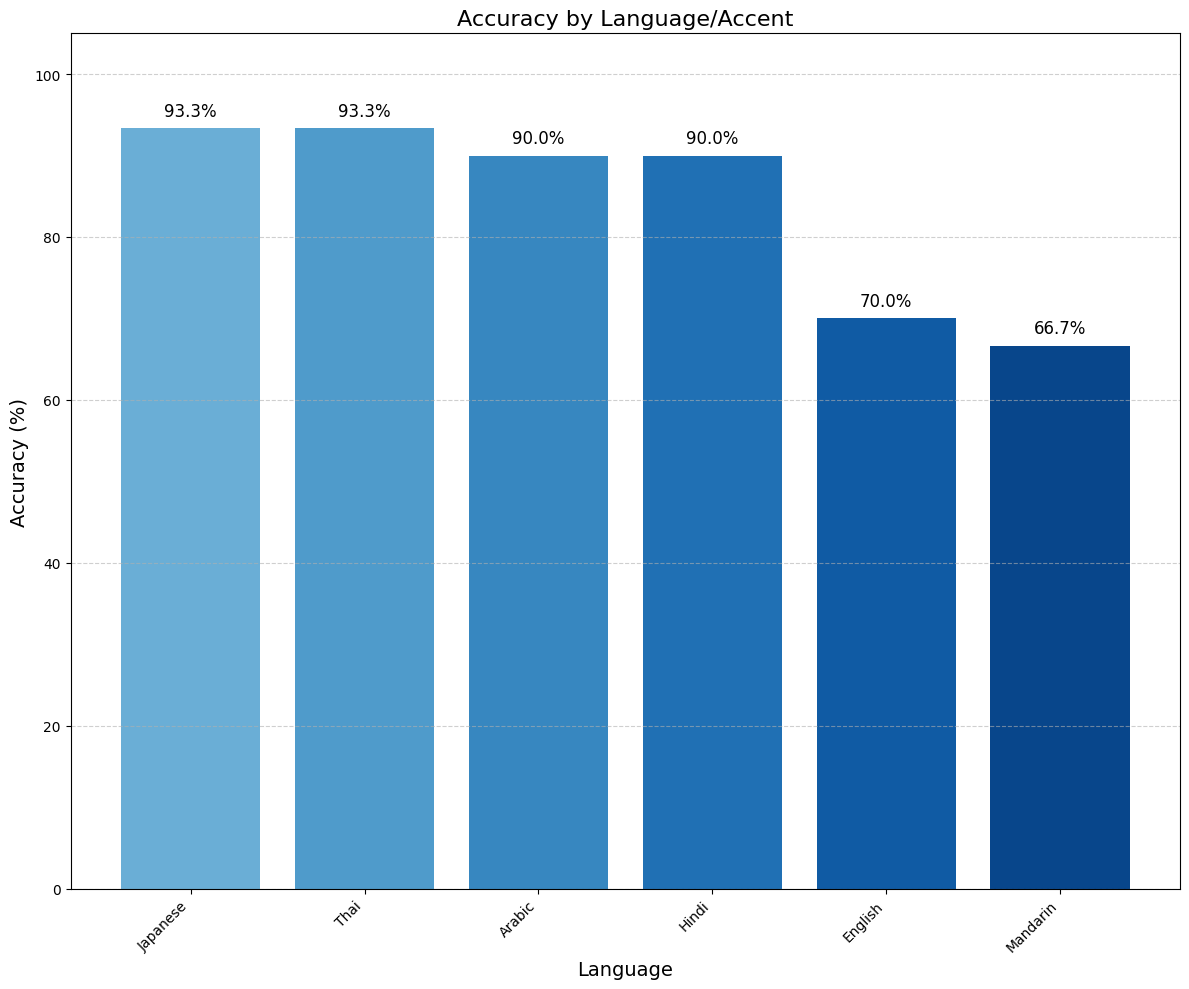


===== ตัวอย่างการทำนาย =====

ตัวอย่างที่ 1:
สำเนียงจริง: english
อันดับ 1: english - 49.2%
อันดับ 2: arabic - 37.5%
อันดับ 3: japanese - 9.6%

ตัวอย่างที่ 2:
สำเนียงจริง: thai
อันดับ 1: thai - 100.0%
อันดับ 2: arabic - 0.0%
อันดับ 3: japanese - 0.0%

ตัวอย่างที่ 3:
สำเนียงจริง: hindi
อันดับ 1: hindi - 99.9%
อันดับ 2: arabic - 0.1%
อันดับ 3: mandarin - 0.0%

ตัวอย่างที่ 4:
สำเนียงจริง: thai
อันดับ 1: thai - 100.0%
อันดับ 2: arabic - 0.0%
อันดับ 3: japanese - 0.0%

ตัวอย่างที่ 5:
สำเนียงจริง: arabic
อันดับ 1: arabic - 99.9%
อันดับ 2: thai - 0.0%
อันดับ 3: hindi - 0.0%

===== กำลังสร้างและฝึกสอนโมเดล Ensemble =====


NameError: name 'build_ensemble_models' is not defined

In [20]:
def main():
    # กำหนดค่าเริ่มต้น
    data_dir = r"D:\Y2.2\Speech_Accent_Detection\main_datadset"  # แก้ไขเป็นโฟลเดอร์ที่เก็บข้อมูลเสียง
    model_dir = "Model"
    
    # สร้างโฟลเดอร์สำหรับเก็บโมเดล
    os.makedirs(model_dir, exist_ok=True)
    
    # เลือกภาษาที่มีลักษณะเสียงแตกต่างกันชัดเจน
    selected_accents = ['thai', 'english', 'mandarin', 'arabic', 'japanese', 'hindi']
    
    # โหลดข้อมูลและเตรียมพร้อม
    result = load_and_preprocess_data(data_dir, selected_accents)
    
    if result[0] is None:
        print("ไม่สามารถดำเนินการต่อได้เนื่องจากไม่มีข้อมูล")
        return
    
    X, y, label_encoder, file_paths = result
    
    # ดำเนินการต่อไป...  
    # บันทึก label encoder ไว้ใช้ในอนาคต
    joblib.dump(label_encoder, os.path.join(model_dir, 'label_encoder.pkl'))
    
    # แบ่งข้อมูลเป็นชุดฝึกสอน, ชุดตรวจสอบ, และชุดทดสอบ
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1))
    
    print(f"ขนาดข้อมูลฝึกสอน: {X_train.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลตรวจสอบ: {X_val.shape[0]} ตัวอย่าง")
    print(f"ขนาดข้อมูลทดสอบ: {X_test.shape[0]} ตัวอย่าง")
    
    # ฝึกสอนโมเดล CNN + RNN hybrid
    print("\n===== กำลังฝึกสอนโมเดล CNN + RNN hybrid =====")
    cnn_rnn_model = build_cnn_rnn_model(X_train.shape[1:], y_train.shape[1])
    cnn_rnn_history, trained_cnn_rnn_model = train_model_with_advanced_techniques(
        cnn_rnn_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
    )
    
    # ประเมินผลโมเดล CNN + RNN hybrid
    print("\n===== ผลลัพธ์การทดสอบโมเดล CNN + RNN hybrid =====")
    class_names = label_encoder.classes_
    evaluate_and_visualize(trained_cnn_rnn_model, X_test, y_test, class_names, label_encoder, cnn_rnn_history)
    
    # ฝึกสอนโมเดล ResNet
    print("\n===== กำลังฝึกสอนโมเดล ResNet =====")
    resnet_model = build_resnet_model(X_train.shape[1:], y_train.shape[1])
    resnet_history, trained_resnet_model = train_model_with_advanced_techniques(
        resnet_model, X_train, y_train, X_val, y_val, 
        epochs=200, batch_size=32, model_path=os.path.join(model_dir, 'accent_resnet_model.h5')
    )
    
    # ประเมินผลโมเดล ResNet
    print("\n===== ผลลัพธ์การทดสอบโมเดล ResNet =====")
    evaluate_and_visualize(trained_resnet_model, X_test, y_test, class_names, label_encoder, resnet_history)
    
    # สร้างและฝึกสอนโมเดล Ensemble
    print("\n===== กำลังสร้างและฝึกสอนโมเดล Ensemble =====")
    ensemble_models = build_ensemble_models(X_train, y_train, num_models=2)
    trained_ensemble, ensemble_histories = train_ensemble_models(
        ensemble_models, X_train, y_train, X_val, y_val, 
        base_model_path=os.path.join(model_dir, 'accent_ensemble_model')
    )
    
    # ประเมินผลโมเดล Ensemble
    print("\n===== ผลลัพธ์การทดสอบโมเดล Ensemble =====")
    # ทำนายด้วย ensemble
    ensemble_preds = ensemble_predict(trained_ensemble, X_test)
    y_pred = np.argmax(ensemble_preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # แสดงผลการประเมิน
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("\n===== รายงานประสิทธิภาพโมเดล Ensemble =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    
    print("\n===== รายงานการจำแนกประเภทโดยละเอียด =====")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # แสดง Confusion Matrix สำหรับ Ensemble
    plt.figure(figsize=(14, 12))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Ensemble Model Confusion Matrix', fontsize=18, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('ensemble_confusion_matrix.png', dpi=300)
    plt.show()
    
    # เปรียบเทียบความแม่นยำของโมเดลทั้งหมด
    plt.figure(figsize=(12, 8))

    # ทำนายด้วยแต่ละโมเดล
    cnn_rnn_preds = trained_cnn_rnn_model.predict(X_test)
    cnn_rnn_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(cnn_rnn_preds, axis=1))

    resnet_preds = trained_resnet_model.predict(X_test)
    resnet_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(resnet_preds, axis=1))

    # ข้อมูลสำหรับกราฟแท่ง
    models = ['CNN+RNN', 'ResNet', 'Ensemble']
    accuracies = [
        cnn_rnn_acc * 100, 
        resnet_acc * 100,
        accuracy * 100
    ]

    # เพิ่มค่าบนแท่ง
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=12
        )
    
    plt.title('Model Comparison: Accuracy', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.ylim(0, 105)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()
    
    print("\nการฝึกสอนและทดสอบโมเดลเสร็จสิ้น")
    def preprocess_audio_file(audio_path, model_dir="Model"):
        try:
            # สกัดคุณลักษณะจากไฟล์เสียง
            features = extract_advanced_features(audio_path)
            if features is None:
                return None
            
            # แปลงเป็น numpy array และเพิ่มมิติแบตช์
            features = np.expand_dims(features, axis=0)
            
            return features
        except Exception as e:
            print(f"เกิดข้อผิดพลาดในการประมวลผลไฟล์เสียง: {str(e)}")
            return None

def predict_accent(audio_path, model_dir="Model"):
    """
    ทำนายสำเนียงจากไฟล์เสียง
    """
    try:
        # โหลด label encoder
        label_encoder = joblib.load(os.path.join(model_dir, 'label_encoder.pkl'))
        
        # โหลดโมเดล ensemble
        models = []
        for i in range(3):
            model_path = os.path.join(model_dir, f'accent_ensemble_model_{i+1}.h5')
            if os.path.exists(model_path):
                models.append(load_model(model_path))
            else:
                print(f"ไม่พบไฟล์โมเดล {model_path}")
        
        if len(models) == 0:
            # ถ้าไม่มีโมเดล ensemble ให้ใช้โมเดล CNN+RNN แทน
            model_path = os.path.join(model_dir, 'accent_cnn_rnn_model.h5')
            if os.path.exists(model_path):
                model = load_model(model_path)
                models = [model]
            else:
                raise FileNotFoundError("ไม่พบไฟล์โมเดล")
        
        # ประมวลผลไฟล์เสียง
        features = preprocess_audio_file(audio_path, model_dir)
        if features is None:
            return "ไม่สามารถประมวลผลไฟล์เสียงได้"
        
        # ทำนาย
        if len(models) > 1:
            # ใช้ ensemble
            predictions = []
            for model in models:
                pred = model.predict(features)
                predictions.append(pred)
            pred_probs = np.mean(predictions, axis=0)[0]
        else:
            # ใช้โมเดลเดียว
            pred_probs = models[0].predict(features)[0]
        
        # จัดอันดับผลการทำนาย
        top_indices = np.argsort(pred_probs)[::-1]
        
        # แสดงผลลัพธ์
        results = []
        for i, idx in enumerate(top_indices[:3]):  # แสดง 3 อันดับแรก
            accent = label_encoder.classes_[idx]
            confidence = pred_probs[idx] * 100
            results.append((accent, confidence))
        
        return results
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการทำนาย: {str(e)}")
        return "เกิดข้อผิดพลาดในการทำนาย"
if __name__ == "__main__":
    main()